# In Depth: Naive Bayes Classification

The previous four chapters have given a general overview of the concepts of machine learning.
In this chapter and the ones that follow, we will be taking a
closer look first at four algorithms for  supervised learning,
and then at four algorithms for unsupervised learning.
We start here with our first supervised method, naive Bayes classification.

Naive Bayes models are a group of extremely fast and simple classification algorithms that are often suitable for very high-dimensional datasets.
Because they are so fast and have so few tunable parameters, they end up being useful as a quick-and-dirty baseline for a classification problem.
This chapter will provide an intuitive explanation of how naive Bayes classifiers work, followed by a few examples of them in action on some datasets.

## Bayesian Classification

Naive Bayes classifiers are built on Bayesian classification methods.
These rely on Bayes's theorem, which is an equation describing the relationship of conditional probabilities of statistical quantities.
In Bayesian classification, we're interested in finding the probability of a label $L$ given some observed features, which we can write as $P(L~|~{\rm features})$.
Bayes's theorem tells us how to express this in terms of quantities we can compute more directly:

$$
P(L~|~{\rm features}) = \frac{P({\rm features}~|~L)P(L)}{P({\rm features})}
$$

If we are trying to decide between two labels—let's call them $L_1$ and $L_2$—then one way to make this decision is to compute the ratio of the posterior probabilities for each label:

$$
\frac{P(L_1~|~{\rm features})}{P(L_2~|~{\rm features})} = \frac{P({\rm features}~|~L_1)}{P({\rm features}~|~L_2)}\frac{P(L_1)}{P(L_2)}
$$

All we need now is some model by which we can compute $P({\rm features}~|~L_i)$ for each label.
Such a model is called a *generative model* because it specifies the hypothetical random process that generates the data.
Specifying this generative model for each label is the main piece of the training of such a Bayesian classifier.
The general version of such a training step is a very difficult task, but we can make it simpler through the use of some simplifying assumptions about the form of this model.

This is where the "naive" in "naive Bayes" comes in: if we make very naive assumptions about the generative model for each label, we can find a rough approximation of the generative model for each class, and then proceed with the Bayesian classification.
Different types of naive Bayes classifiers rest on different naive assumptions about the data, and we will examine a few of these in the following sections.

We begin with the standard imports:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-whitegrid')

## Gaussian Naive Bayes

Perhaps the easiest naive Bayes classifier to understand is Gaussian naive Bayes.
With this classifier, the assumption is that *data from each label is drawn from a simple Gaussian distribution*.
Imagine that we have the following data, shown in Figure 41-1:

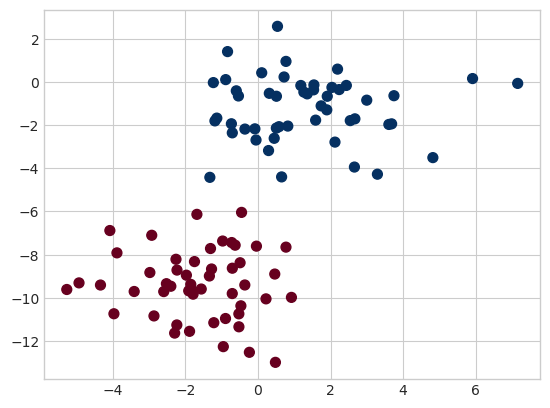

In [2]:
from sklearn.datasets import make_blobs
X, y = make_blobs(100, 2, centers=2, random_state=2, cluster_std=1.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu');

The simplest Gaussian model is to assume that the data is described by a Gaussian distribution with no covariance between dimensions.
This model can be fit by computing the mean and standard deviation of the points within each label, which is all we need to define such a distribution.
The result of this naive Gaussian assumption is shown in the following figure:

![(run code in Appendix to generate image)](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/images/05.05-gaussian-NB.png?raw=1)
[figure source in Appendix](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/06.00-Figure-Code.ipynb#Gaussian-Naive-Bayes)

The ellipses here represent the Gaussian generative model for each label, with larger probability toward the center of the ellipses.
With this generative model in place for each class, we have a simple recipe to compute the likelihood $P({\rm features}~|~L_1)$ for any data point, and thus we can quickly compute the posterior ratio and determine which label is the most probable for a given point.

This procedure is implemented in Scikit-Learn's `sklearn.naive_bayes.GaussianNB` estimator:

In [3]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X, y);

Let's generate some new data and predict the label:

In [4]:
rng = np.random.RandomState(0)
Xnew = [-6, -14] + [14, 18] * rng.rand(2000, 2)
ynew = model.predict(Xnew)

Now we can plot this new data to get an idea of where the decision boundary is (see the following figure):

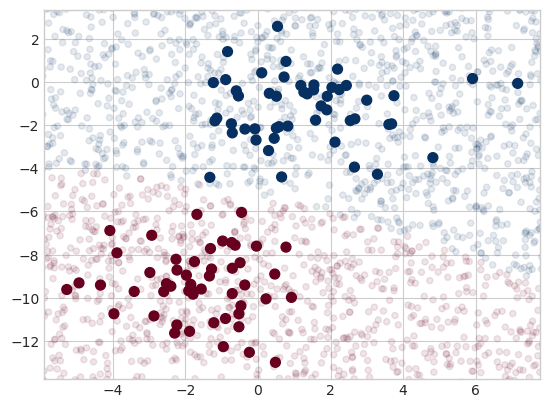

In [5]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
lim = plt.axis()
plt.scatter(Xnew[:, 0], Xnew[:, 1], c=ynew, s=20, cmap='RdBu', alpha=0.1)
plt.axis(lim);

We see a slightly curved boundary in the classifications—in general, the boundary produced by a Gaussian naive Bayes model will be quadratic.

A nice aspect of this Bayesian formalism is that it naturally allows for probabilistic classification, which we can compute using the `predict_proba` method:

In [6]:
yprob = model.predict_proba(Xnew)
yprob[-8:].round(2)

array([[0.89, 0.11],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.15, 0.85]])

The columns give the posterior probabilities of the first and second labels, respectively.
If you are looking for estimates of uncertainty in your classification, Bayesian approaches like this can be a good place to start.

Of course, the final classification will only be as good as the model assumptions that lead to it, which is why Gaussian naive Bayes often does not produce very good results.
Still, in many cases—especially as the number of features becomes large—this assumption is not detrimental enough to prevent Gaussian naive Bayes from being a reliable method.

## Multinomial Naive Bayes

The Gaussian assumption just described is by no means the only simple assumption that could be used to specify the generative distribution for each label.
Another useful example is multinomial naive Bayes, where the features are assumed to be generated from a simple multinomial distribution.
The multinomial distribution describes the probability of observing counts among a number of categories, and thus multinomial naive Bayes is most appropriate for features that represent counts or count rates.

The idea is precisely the same as before, except that instead of modeling the data distribution with the best-fit Gaussian, we model it with a best-fit multinomial distribution.

### Example: Classifying Text

One place where multinomial naive Bayes is often used is in text classification, where the features are related to word counts or frequencies within the documents to be classified.
We discussed the extraction of such features from text in [Feature Engineering](05.04-Feature-Engineering.ipynb); here we will use the sparse word count features from the 20 Newsgroups corpus made available through Scikit-Learn to show how we might classify these short documents into categories.

Let's download the data and take a look at the target names:

In [7]:
from sklearn.datasets import fetch_20newsgroups

data = fetch_20newsgroups()
data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [8]:
data.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

For simplicity here, we will select just a few of these categories and download the training and testing sets:

In [9]:
categories = ['talk.religion.misc', 'soc.religion.christian',
              'sci.space', 'comp.graphics']
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

Here is a representative entry from the data:

In [10]:
print(train.data[5][48:])

Subject: Federal Hearing
Originator: dmcgee@uluhe
Organization: School of Ocean and Earth Science and Technology
Distribution: usa
Lines: 10


Fact or rumor....?  Madalyn Murray O'Hare an atheist who eliminated the
use of the bible reading and prayer in public schools 15 years ago is now
going to appear before the FCC with a petition to stop the reading of the
Gospel on the airways of America.  And she is also campaigning to remove
Christmas programs, songs, etc from the public schools.  If it is true
then mail to Federal Communications Commission 1919 H Street Washington DC
20054 expressing your opposition to her request.  Reference Petition number

2493.



In order to use this data for machine learning, we need to be able to convert the content of each string into a vector of numbers.
For this we will use the TF-IDF vectorizer (introduced in [Feature Engineering](05.04-Feature-Engineering.ipynb)), and create a pipeline that attaches it to a multinomial naive Bayes classifier:

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

model = make_pipeline(TfidfVectorizer(), MultinomialNB())

With this pipeline, we can apply the model to the training data and predict labels for the test data:

In [12]:
model.fit(train.data, train.target)
labels = model.predict(test.data)

Now that we have predicted the labels for the test data, we can evaluate them to learn about the performance of the estimator.
For example, let's take a look at the confusion matrix between the true and predicted labels for the test data (see the following figure):

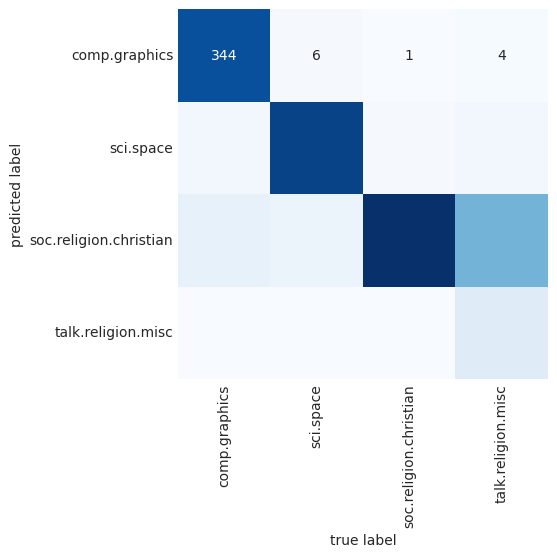

In [13]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(test.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=train.target_names, yticklabels=train.target_names,
            cmap='Blues')
plt.xlabel('true label')
plt.ylabel('predicted label');

Evidently, even this very simple classifier can successfully separate space discussions from computer discussions, but it gets confused between discussions about religion and discussions about Christianity.
This is perhaps to be expected!

The cool thing here is that we now have the tools to determine the category for *any* string, using the `predict` method of this pipeline.
Here's a utility function that will return the prediction for a single string:

In [14]:
def predict_category(s, train=train, model=model):
    pred = model.predict([s])
    return train.target_names[pred[0]]

Let's try it out:

In [15]:
predict_category('sending a payload to the ISS')

'sci.space'

In [16]:
predict_category('discussing the existence of God')

'soc.religion.christian'

In [17]:
predict_category('determining the screen resolution')

'comp.graphics'

Remember that this is nothing more sophisticated than a simple probability model for the (weighted) frequency of each word in the string; nevertheless, the result is striking.
Even a very naive algorithm, when used carefully and trained on a large set of high-dimensional data, can be surprisingly effective.

## When to Use Naive Bayes

Because naive Bayes classifiers make such stringent assumptions about data, they will generally not perform as well as more complicated models.
That said, they have several advantages:

- They are fast for both training and prediction.
- They provide straightforward probabilistic prediction.
- They are often easily interpretable.
- They have few (if any) tunable parameters.

These advantages mean a naive Bayes classifier is often a good choice as an initial baseline classification.
If it performs suitably, then congratulations: you have a very fast, very interpretable classifier for your problem.
If it does not perform well, then you can begin exploring more sophisticated models, with some baseline knowledge of how well they should perform.

Naive Bayes classifiers tend to perform especially well in the following situations:

- When the naive assumptions actually match the data (very rare in practice)
- For very well-separated categories, when model complexity is less important
- For very high-dimensional data, when model complexity is less important

The last two points seem distinct, but they actually are related: as the dimensionality of a dataset grows, it is much less likely for any two points to be found close together (after all, they must be close in *every single dimension* to be close overall).
This means that clusters in high dimensions tend to be more separated, on average, than clusters in low dimensions, assuming the new dimensions actually add information.
For this reason, simplistic classifiers like the ones discussed here tend to work as well or better than more complicated classifiers as the dimensionality grows: once you have enough data, even a simple model can be very powerful.

# Naive Bayes Classification of Exoplanet Data
We downloaded exoplanet data from the [NASA Exoplanet Archive Planetary Systems Data](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=PS). We download the data in a CSV file.

The dataset contains several columns, including one called `discoveymethod`, which specifies which method was used to first detect the planet. We will use this metric as the one we would like to predict with our Naive Bayes algorithm. This isn't a prefect property to predict, as a the method of initial discovery doesn't necessarily indicate that the planet is particularly well suited to be discovered in that way. But we will use that nonetheless.

In [18]:
import pandas as pd

In [19]:
exo_df = pd.read_csv('PS_2024.05.02_07.53.02.csv', skiprows=range(60)) # skipping the first 60 metadata rows.
exo_df = exo_df.drop('st_metratio', axis='columns') # getting rid of this column as it is non-numeric
exo_df

,default_flag,sy_snum,sy_pnum,sy_mnum,cb_flag,discoverymethod,rv_flag,pul_flag,ptv_flag,tran_flag,...,st_dens,st_vsin,st_rotp,st_radv,sy_pm,sy_dist,sy_plx,sy_vmag,sy_kmag,sy_gaiamag
0,0,2,1,0,0,Radial Velocity,1,0,0,0,...,NaN,NaN,NaN,NaN,140.383627,93.1846,10.71040,4.72307,2.282,4.44038
1,0,2,1,0,0,Radial Velocity,1,0,0,0,...,NaN,1.20,NaN,NaN,140.383627,93.1846,10.71040,4.72307,2.282,4.44038
2,1,2,1,0,0,Radial Velocity,1,0,0,0,...,NaN,NaN,NaN,NaN,140.383627,93.1846,10.71040,4.72307,2.282,4.44038
3,1,1,1,0,0,Radial Velocity,1,0,0,0,...,NaN,NaN,NaN,NaN,10.679019,125.3210,7.95388,5.01300,1.939,4.56216
4,0,1,1,0,0,Radial Velocity,1,0,0,0,...,NaN,NaN,NaN,NaN,10.679019,125.3210,7.95388,5.01300,1.939,4.56216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35916,0,2,3,0,0,Radial Velocity,1,0,0,0,...,NaN,NaN,NaN,-28.66,419.857418,13.4054,74.57110,4.09565,2.859,3.98687
35917,1,1,1,0,0,Radial Velocity,1,0,0,0,...,NaN,1.78,NaN,NaN,42.335113,52.5973,18.99390,4.30490,2.184,4.03040
35918,0,1,1,0,0,Radial Velocity,1,0,0,0,...,NaN,NaN,NaN,NaN,129.341395,56.1858,17.77250,4.70964,2.171,4.42501
35919,0,1,1,0,0,Radial Velocity,1,0,0,0,...,NaN,NaN,NaN,NaN,129.341395,56.1858,17.77250,4.70964,2.171,4.42501


After getting rid of all non-numeric columns, and columns that have an apparent codependency (for instance mass in Earth Masses and mass in Jupiter masses), we are left with about 55 columns. However, many of these columns still contain a significant amount of `NaN` values, which we won't be able to use with the Naive Bayes method.

We will first visualise the number of `NaN` values for each available column.

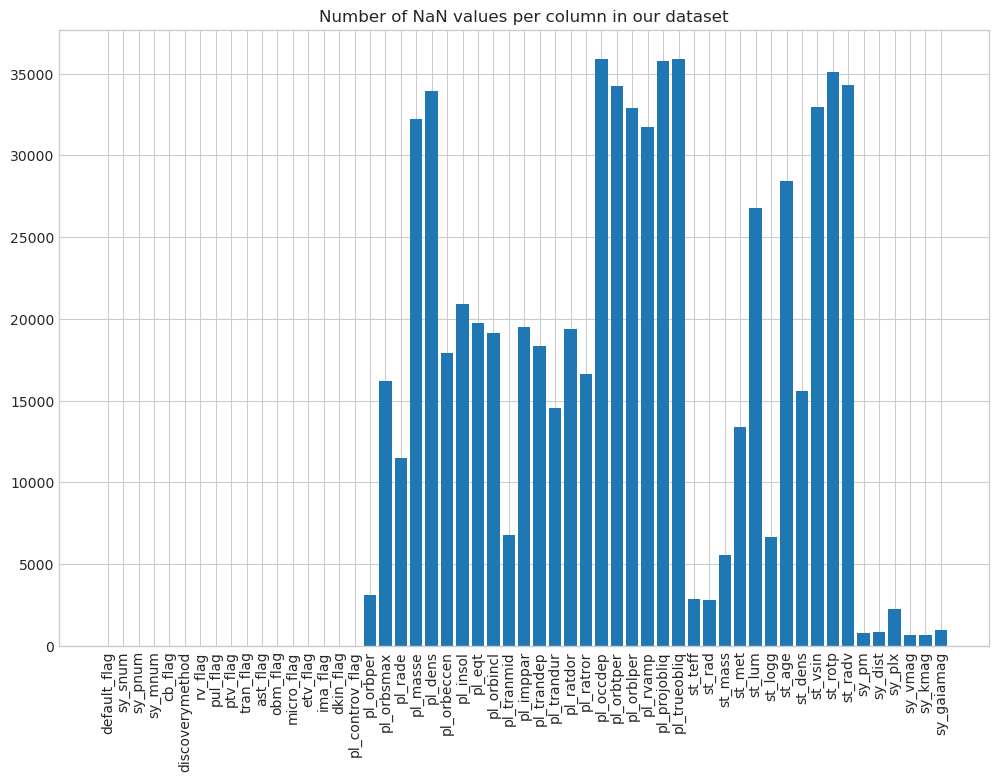

In [20]:
### How many columns have an unreasonable amount of NaN values? We should remove those from consideration
na_counts = exo_df.isna().sum()

plt.figure(figsize=(12,8))
plt.bar(na_counts.index, na_counts.values)
plt.xticks(rotation=90)
plt.title('Number of NaN values per column in our dataset')
plt.show()

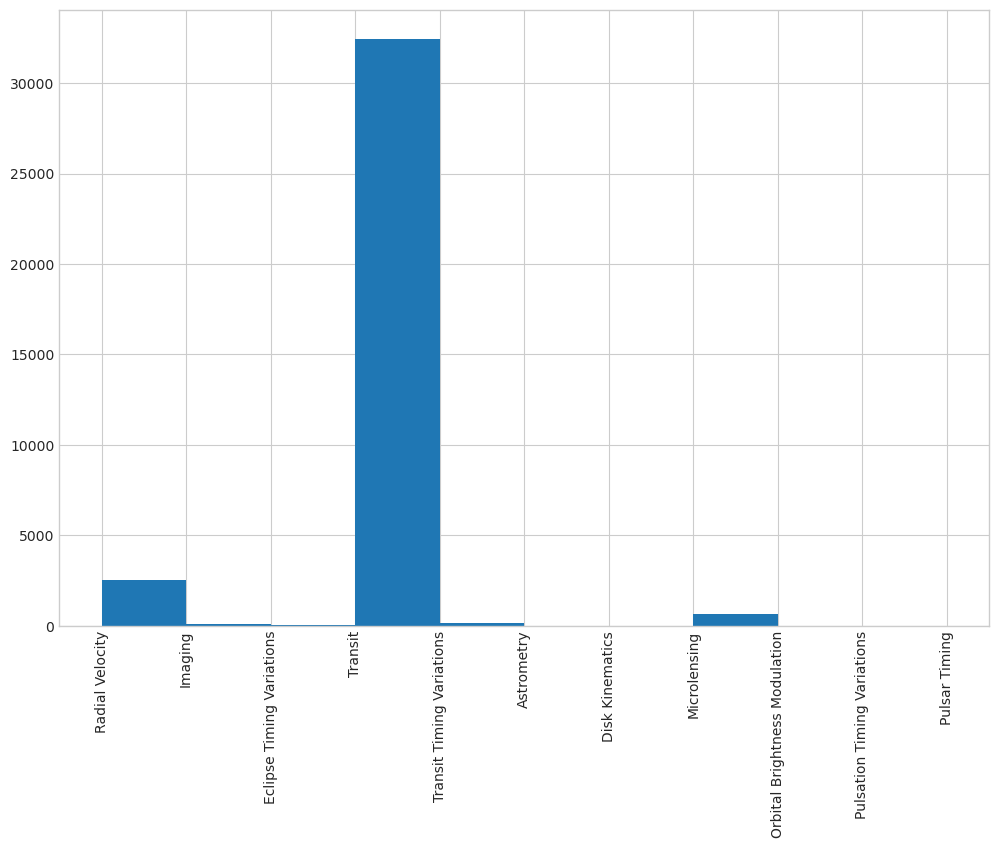

In [21]:
plt.figure(figsize=(12,8))

plt.hist(exo_df['discoverymethod'])

plt.xticks(rotation=90)
plt.show()

We can see that the discovery method distribution in our dataset is very uneven, with the most number of planets being discovered through transits, followed by radial velocity.

We will attempt to maximise the variety of number of planets in our dataset so that we may as many discovery methods as possible. To do this, we will preserve as many rows (with non `NaN` values) by dropping as many columns with `NaN` values as possible.

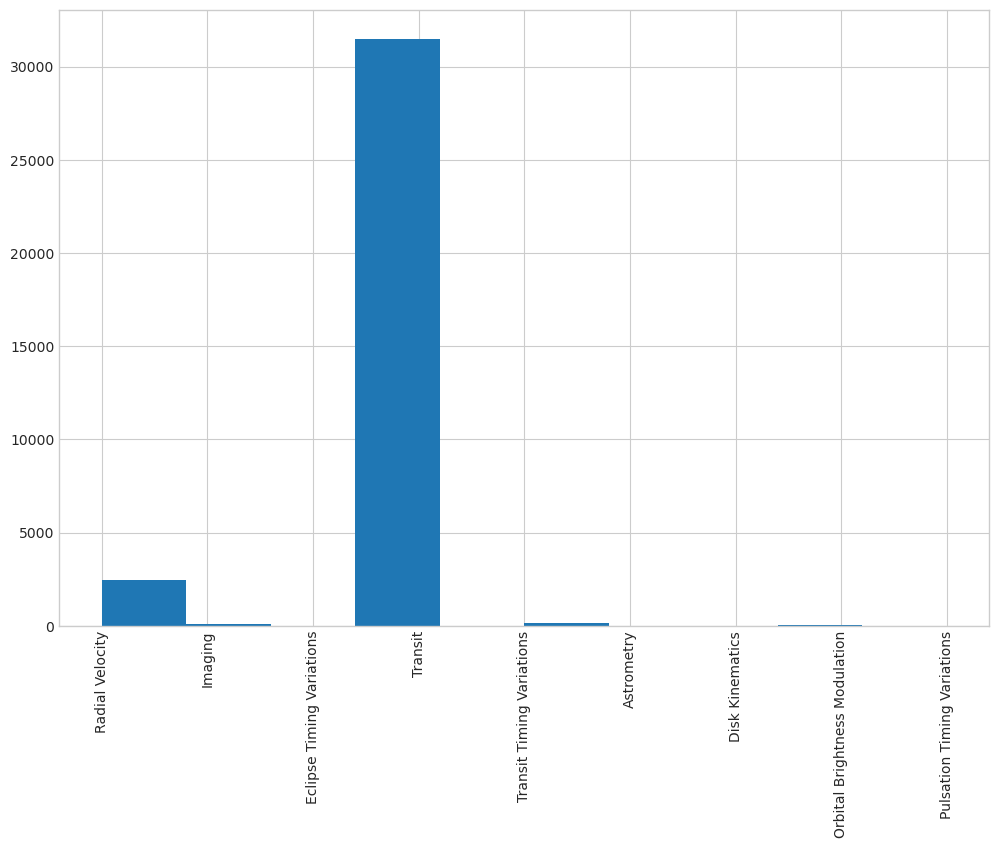

In [22]:
exo_df_filt = exo_df[na_counts[na_counts < 2000].index]
exo_df_filt = exo_df_filt.dropna()

plt.figure(figsize=(12,8))

plt.hist(exo_df_filt['discoverymethod'])

plt.xticks(rotation=90)
plt.show()

In [103]:
methods = exo_df_filt['discoverymethod'].unique()
method_dict = {i: methods[i] for i in range(len(methods))} 

def catagorise_method(row, methods=methods):
    return np.where(methods == row['discoverymethod'])[0][0]

def catagorise_dmethod(row, method_dict=method_dict):
    return method_dict[row['method']]

exo_df_filt['method'] = exo_df_filt.apply(catagorise_method, axis=1)
exo_df_filt

,default_flag,sy_snum,sy_pnum,sy_mnum,cb_flag,discoverymethod,rv_flag,pul_flag,ptv_flag,tran_flag,...,pl_orbper,st_teff,st_rad,sy_pm,sy_dist,sy_plx,sy_vmag,sy_kmag,sy_gaiamag,method
1,0,2,1,0,0,Radial Velocity,1,0,0,0,...,326.03000,4742.00,19.00,140.383627,93.1846,10.71040,4.72307,2.282,4.44038,0
2,1,2,1,0,0,Radial Velocity,1,0,0,0,...,323.21000,4874.00,13.76,140.383627,93.1846,10.71040,4.72307,2.282,4.44038,0
3,1,1,1,0,0,Radial Velocity,1,0,0,0,...,516.21997,4213.00,29.79,10.679019,125.3210,7.95388,5.01300,1.939,4.56216,0
5,0,1,1,0,0,Radial Velocity,1,0,0,0,...,516.22000,4340.00,24.08,10.679019,125.3210,7.95388,5.01300,1.939,4.56216,0
6,1,1,1,0,0,Radial Velocity,1,0,0,0,...,186.76000,4888.00,11.55,299.252618,75.4392,13.22890,5.23133,2.331,4.91781,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35912,0,2,3,0,0,Radial Velocity,1,0,0,0,...,1281.50700,6089.00,1.64,419.857418,13.4054,74.57110,4.09565,2.859,3.98687,0
35913,0,2,3,0,0,Radial Velocity,1,0,0,0,...,1278.10000,6105.51,1.64,419.857418,13.4054,74.57110,4.09565,2.859,3.98687,0
35917,1,1,1,0,0,Radial Velocity,1,0,0,0,...,385.20000,4836.00,11.22,42.335113,52.5973,18.99390,4.30490,2.184,4.03040,0
35919,0,1,1,0,0,Radial Velocity,1,0,0,0,...,136.75000,4780.00,12.00,129.341395,56.1858,17.77250,4.70964,2.171,4.42501,0


We have retained 34236 rows with complete information, and are left with 23 columns. We will divide these into two sets for training and testing respectively.

In [24]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [25]:
y = exo_df_filt['method']
X = exo_df_filt

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=3)

In [27]:
clf = GaussianNB()
clf.fit(X_train.drop(['discoverymethod', 'method'], axis='columns'), y_train)

GaussianNB()

The prediction results are as follows:

In [28]:
y_pred = clf.predict(X_test.drop(['discoverymethod', 'method'], axis='columns'))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.98      0.89      1283
           1       1.00      1.00      1.00        52
           2       1.00      1.00      1.00         7
           3       1.00      0.98      0.99     15708
           4       0.21      0.17      0.19        59
           7       0.08      1.00      0.15         8
           8       0.00      0.00      0.00         1

    accuracy                           0.97     17118
   macro avg       0.59      0.73      0.60     17118
weighted avg       0.98      0.97      0.98     17118



/home/sshamsi/miniconda3/envs/naivebayes/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sshamsi/miniconda3/envs/naivebayes/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sshamsi/miniconda3/envs/naivebayes/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

We will now create a heatmap.

In [29]:
X_test_pred = clf.predict(X_test.drop(['discoverymethod', 'method'], axis='columns'))

mat = confusion_matrix(X_test['method'], X_test_pred)

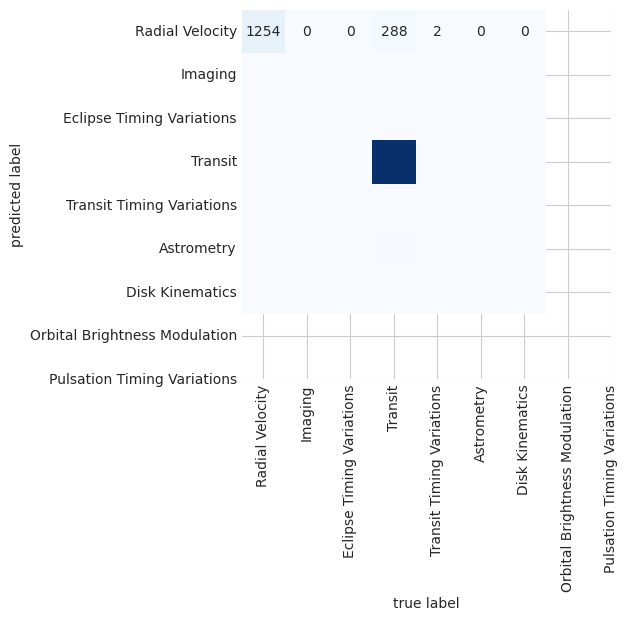

In [30]:
sns.heatmap(np.transpose(mat), square=True, annot=True, fmt='d', cbar=False, xticklabels=methods, yticklabels=methods, cmap='Blues')
plt.xlabel('true label')
plt.ylabel('predicted label');

The heatmap shows a successful classifier. Although, we do not see a lot of agreement on methods besides transits and radial velocities. This makes sense as there is simply not enough data to train and predict these methods.

### Changes

What happens when we try to vary the amount of columns??

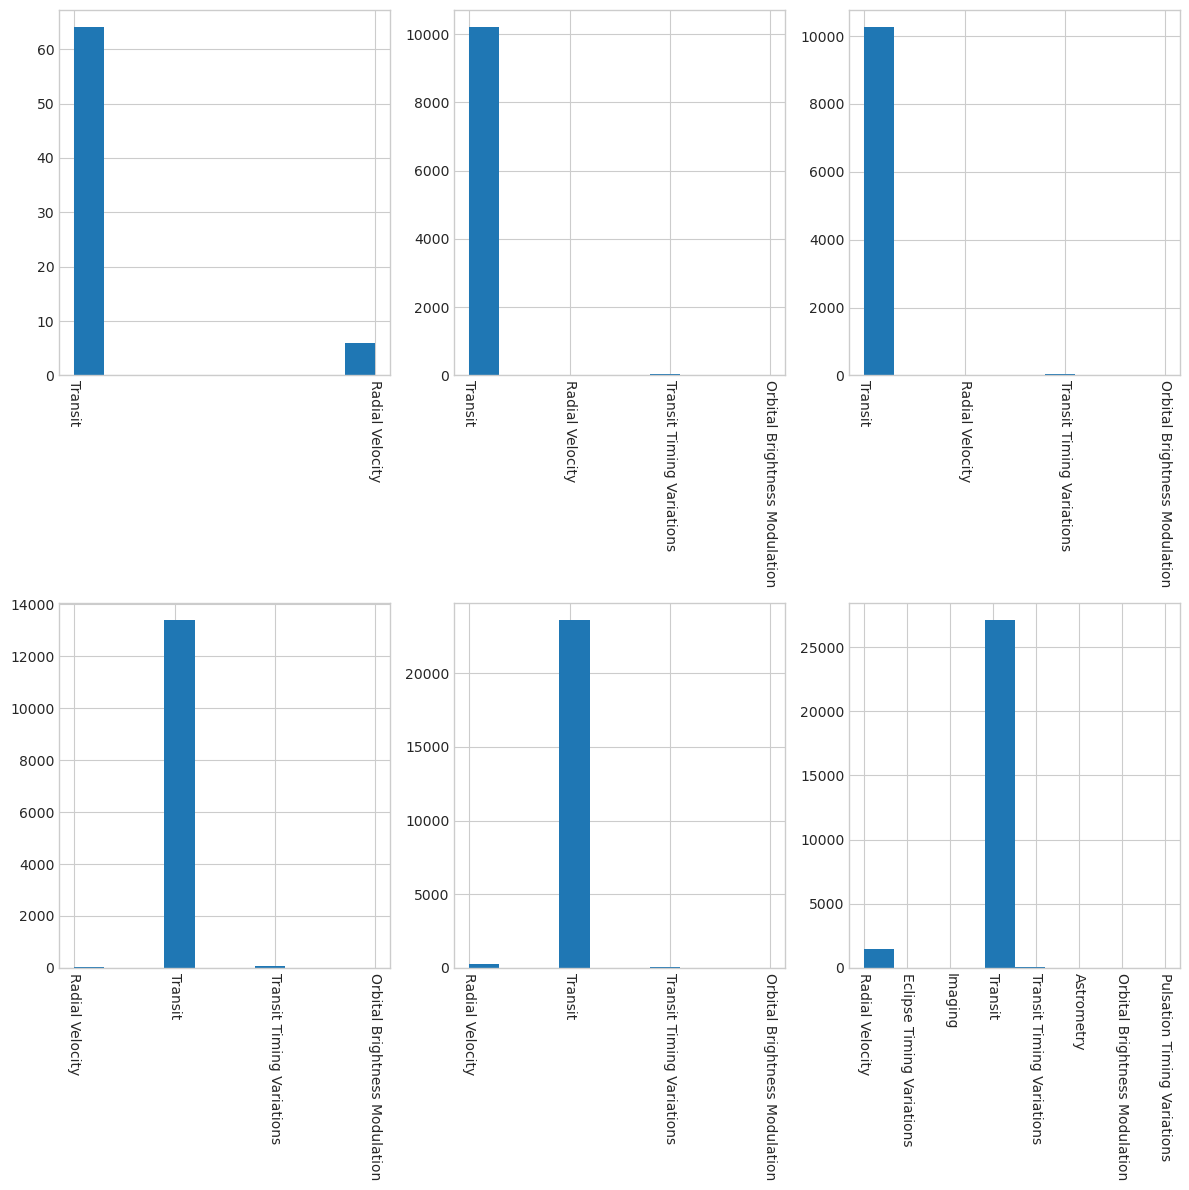

In [31]:
cut_offs = [30000, 25000, 20000, 15000, 10000, 5000]

fig, axs = plt.subplots(2, 3, figsize=(12,12))

axs = axs.ravel()
for i, ax in enumerate(axs):
    cutoff = cut_offs[i]
    exo_df_filt = exo_df[na_counts[na_counts < cutoff].index]
    exo_df_filt = exo_df_filt.dropna()
    ax.hist(exo_df_filt['discoverymethod'])
    ax.xaxis.label.set_size(1)
    ax.tick_params(axis='x', labelrotation=-90)

fig.tight_layout()

What happens with the Naive Bayes classifications with these varying numbers for our cutoffs?

In [32]:
print('Discovery Method Key\n', method_dict, '\n')

for i, cutoff in enumerate(cut_offs):
    exo_df_filt = exo_df[na_counts[na_counts < cutoff].index]
    exo_df_filt = exo_df_filt.dropna()
    exo_df_filt['method'] = exo_df_filt.apply(catagorise_method, axis=1)
    
    y = exo_df_filt['method']
    X = exo_df_filt
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=3)

    clf = GaussianNB()
    clf.fit(X_train.drop(['discoverymethod', 'method'], axis='columns'), y_train)

    y_pred = clf.predict(X_test.drop(['discoverymethod', 'method'], axis='columns'))

    print("Cutoff:\t{}\n".format(cutoff))
    print(exo_df_filt['discoverymethod'].value_counts(), '\n')
    print(classification_report(y_test, y_pred))
    print('\n\n')

Discovery Method Key
 {0: 'Radial Velocity', 1: 'Imaging', 2: 'Eclipse Timing Variations', 3: 'Transit', 4: 'Transit Timing Variations', 5: 'Astrometry', 6: 'Disk Kinematics', 7: 'Orbital Brightness Modulation', 8: 'Pulsation Timing Variations'} 

Cutoff:	30000

discoverymethod
Transit            64
Radial Velocity     6
Name: count, dtype: int64 

              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           3       0.94      1.00      0.97        32

    accuracy                           0.94        35
   macro avg       0.97      0.67      0.73        35
weighted avg       0.95      0.94      0.93        35




Cutoff:	25000

discoverymethod
Transit                          10199
Transit Timing Variations           44
Radial Velocity                      6
Orbital Brightness Modulation        4
Name: count, dtype: int64 

              precision    recall  f1-score   support

           0       0.36      1.00      0.53      

/home/sshamsi/miniconda3/envs/naivebayes/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sshamsi/miniconda3/envs/naivebayes/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sshamsi/miniconda3/envs/naivebayes/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Cutoff:	15000

discoverymethod
Transit                          13403
Transit Timing Variations           54
Radial Velocity                     21
Orbital Brightness Modulation        5
Name: count, dtype: int64 

              precision    recall  f1-score   support

           0       0.10      0.67      0.18        12
           3       1.00      0.28      0.44      6694
           4       0.01      1.00      0.01        33
           7       1.00      0.33      0.50         3

    accuracy                           0.28      6742
   macro avg       0.53      0.57      0.28      6742
weighted avg       0.99      0.28      0.43      6742




Cutoff:	10000

discoverymethod
Transit                          23631
Radial Velocity                    286
Transit Timing Variations           90
Orbital Brightness Modulation       10
Name: count, dtype: int64 

              precision    recall  f1-score   support

           0       0.39      1.00      0.56       141
           3       1.00

/home/sshamsi/miniconda3/envs/naivebayes/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sshamsi/miniconda3/envs/naivebayes/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sshamsi/miniconda3/envs/naivebayes/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

We will try to extend the exoplanet data with SMOTE and RandomOversampler

In [94]:
from sklearn.preprocessing import StandardScaler, normalize
from scipy import ndimage
from imblearn.over_sampling import SMOTE, RandomOverSampler

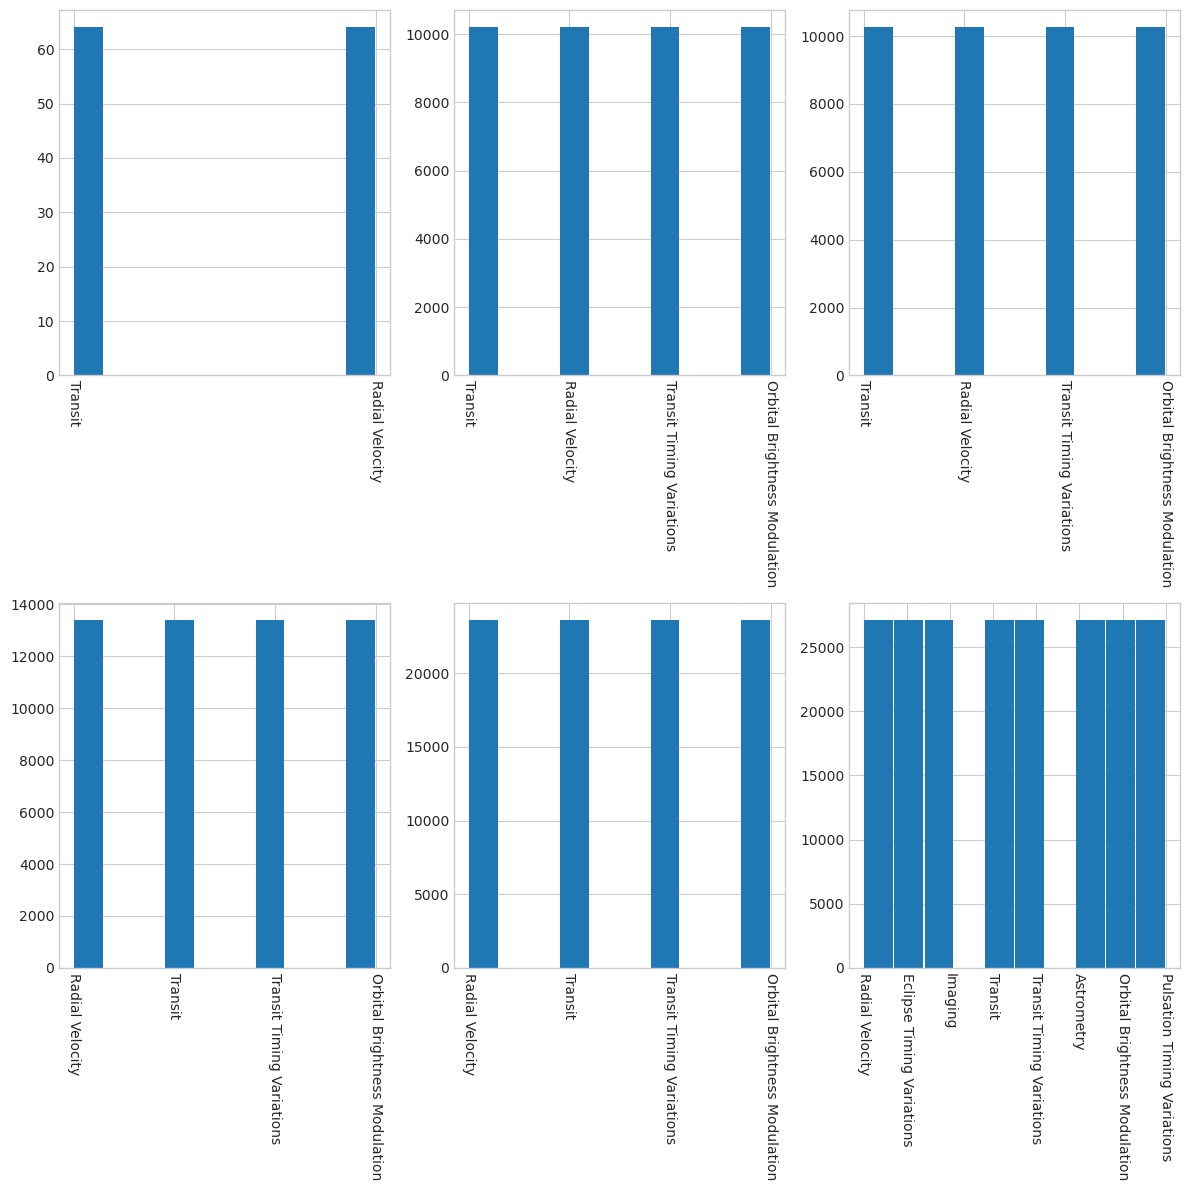

In [109]:
model_SMOTE = SMOTE(k_neighbors=2)
model_random = RandomOverSampler(random_state=42)

fig, axs = plt.subplots(2, 3, figsize=(12,12))
axs = axs.ravel()

for i, ax in enumerate(axs):
    cutoff = cut_offs[i]
    exo_df_filt = exo_df[na_counts[na_counts < cutoff].index]
    exo_df_filt = exo_df_filt.dropna()
    exo_df_filt['method'] = exo_df_filt.apply(catagorise_method, axis=1)

    X = exo_df_filt.drop(['method', 'discoverymethod'], axis=1)
    y = exo_df_filt['method'].astype(int)

    try:
        ov_train_x, ov_train_y = model_SMOTE.fit_resample(X, y)
    except:
        ov_train_x, ov_train_y = model_random.fit_resample(X, y)

    ov_train_x['method'] = ov_train_y
    ov_train_x['deliverymethod'] = ov_train_x.apply(catagorise_dmethod, axis=1)
    
    ax.hist(ov_train_x['deliverymethod'],rwidth=0.95)
    ax.xaxis.label.set_size(1)
    ax.tick_params(axis='x', labelrotation=-90)


# exo_df_filt = exo_df[na_counts[na_counts < cutoff].index]
# exo_df_filt = exo_df_filt.dropna()
# exo_df_filt['method'] = exo_df_filt.apply(catagorise_method, axis=1)

# X = exo_df_filt.drop(['method', 'discoverymethod'], axis=1)
# y = exo_df_filt['method'].astype(int)

# # X = normalize(X)
# # X = ndimage.filters.gaussian_filter(X, sigma=10)
# # std_scaler = StandardScaler()
# # X = std_scaler.fit_transform(X)




    
# ov_train_y = ov_train_y.astype('int')




fig.tight_layout()

In [111]:
print('Discovery Method Key\n', method_dict, '\n')

for i, cutoff in enumerate(cut_offs):
    exo_df_filt = exo_df[na_counts[na_counts < cutoff].index]
    exo_df_filt = exo_df_filt.dropna()
    exo_df_filt['method'] = exo_df_filt.apply(catagorise_method, axis=1)

    X = exo_df_filt.drop(['method', 'discoverymethod'], axis=1)
    y = exo_df_filt['method'].astype(int)

    try:
        ov_train_x, ov_train_y = model_SMOTE.fit_resample(X, y)
    except:
        ov_train_x, ov_train_y = model_random.fit_resample(X, y)

    ov_train_x['method'] = ov_train_y
    ov_train_x['discoverymethod'] = ov_train_x.apply(catagorise_dmethod, axis=1)

    exo_df_filt = ov_train_x

    y = exo_df_filt['method']
    X = exo_df_filt
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=3)

    clf = GaussianNB()
    clf.fit(X_train.drop(['discoverymethod', 'method'], axis='columns'), y_train)

    y_pred = clf.predict(X_test.drop(['discoverymethod', 'method'], axis='columns'))

    print("Cutoff:\t{}\n".format(cutoff))
    print(exo_df_filt['discoverymethod'].value_counts(), '\n')
    print(classification_report(y_test, y_pred))
    print('\n\n')
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=3)

    clf = GaussianNB()
    clf.fit(X_train.drop(['discoverymethod', 'method'], axis='columns'), y_train)

    y_pred = clf.predict(X_test.drop(['discoverymethod', 'method'], axis='columns'))

    print("Cutoff:\t{}\n".format(cutoff))
    print(exo_df_filt['discoverymethod'].value_counts(), '\n')
    print(classification_report(y_test, y_pred))
    print('\n\n')

Discovery Method Key
 {0: 'Radial Velocity', 1: 'Eclipse Timing Variations', 2: 'Imaging', 3: 'Transit', 4: 'Transit Timing Variations', 5: 'Astrometry', 6: 'Orbital Brightness Modulation', 7: 'Pulsation Timing Variations'} 

Cutoff:	30000

discoverymethod
Transit            64
Radial Velocity    64
Name: count, dtype: int64 

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        36
           3       0.97      1.00      0.98        28

    accuracy                           0.98        64
   macro avg       0.98      0.99      0.98        64
weighted avg       0.98      0.98      0.98        64




Cutoff:	30000

discoverymethod
Transit            64
Radial Velocity    64
Name: count, dtype: int64 

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        36
           3       0.97      1.00      0.98        28

    accuracy                           0.98        64
   macro avg       0